In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os, sys
import numpy as np 
# import pandas as pd 
import matplotlib.pyplot as plt
# import geopandas as gpd
import sklearn, sklearn.cross_decomposition
from sklearn.cross_decomposition import CCA
sys.path.append('../src/')
sys.path.append('../content/')
import data_utils as du
import loadpaths
path_dict_pecl = loadpaths.loadpaths()
import analysis_utils as au
from matplotlib import colormaps
from matplotlib.patches import Rectangle
import scipy.optimize as opt


In [4]:

# Then collect from all patches the alpha and dyn data
patches = 10
hypotheses = []
features = []
sentinel = []
for p in range(patches):
    (data_sent, data_alpha, data_dyn, data_worldclim, data_dsm) = du.load_all_modalities_from_name(name=f'pecl-fig-{p}', path_folder='../content/sample_data', verbose=1)
    # Land coverage serves as hypotheses
    hypotheses.append(data_dyn.data)
    # This can definitely be cleaner but I use nan for undefined values
    f_dat = data_alpha.data
    f_dat[~np.isfinite(f_dat)] = np.nan
    features.append(f_dat)    
    sentinel.append(data_sent.data)

# Z-score across patches for each feature and each hypothesis
feat_m = np.stack([np.nanmean(f) for f in np.stack(features, axis=-1)])
feat_std = np.stack([np.nanstd(f) for f in np.stack(features, axis=-1)])
features = [(f - feat_m[:,None,None])/feat_std[:,None,None] for f in features]
hyp_m = np.stack([np.nanmean(h) for h in np.stack(hypotheses, axis=-1)])
hyp_std = np.stack([np.nanstd(h) for h in np.stack(hypotheses, axis=-1)])
hypotheses = [(h - hyp_m[:,None,None])/hyp_std[:,None,None] for h in hypotheses]


Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
DSM: (1, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
DSM: (1, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Se

In [219]:

# Then collect from all patches the alpha and dyn data
patches = 10
hypotheses = []
features = []
features_original = []
sentinel = []
for p in range(patches):
    (data_sent, data_alpha, data_dyn, data_worldclim) = du.load_all_modalities_from_name(name=f'pecl-fig-{p}', path_folder='../content/sample_data', verbose=1)
    # Land coverage serves as hypotheses
    hypotheses.append(data_dyn.data)
    # This can definitely be cleaner but I use nan for undefined values
    f_dat = data_alpha.data
    f_dat[~np.isfinite(f_dat)] = 0
    # f_dat[np.logical_and(f_dat < 0.05, f_dat > -0.05)] = 0  # Thresholding to remove noise
    features_original.append(f_dat)
    
    cca = CCA(n_components=2)
    X = f_dat.reshape(64, -1).T
    Y = data_dyn.data.reshape(data_dyn.shape[0], -1).T
    X_c, Y_c = cca.fit_transform(X, Y)
    X_hat = X_c @ cca.x_weights_.T
    X_residual = X - X_hat
    f_dat_residual = X_residual.T.reshape(f_dat.shape)
    # print(X_residual.shape, f_dat.shape, X.shape, f_dat_residual.shape)
    # assert False
    features.append(f_dat_residual)
    sentinel.append(data_sent.data)

Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray

In [226]:

def ravel_features(features):
    assert len(features.shape) == 4
    n_patches, n_features, nx, ny = features.shape
    return np.swapaxes(features, 0, 1).reshape((n_features, -1))

def unravel_features(raveled, n_patches, nx, ny):
    n_features = raveled.shape[0]
    return np.swapaxes(raveled.reshape((n_features, n_patches, nx, ny)), 0, 1)

# Then collect from all patches the alpha and dyn data
patches = 10
hypotheses = []
features = []
features_original = []
sentinel = []
for p in range(patches):
    (data_sent, data_alpha, data_dyn, data_worldclim) = du.load_all_modalities_from_name(name=f'pecl-fig-{p}', path_folder='../content/sample_data', verbose=1)
    # Land coverage serves as hypotheses
    hypotheses.append(data_dyn.data)
    # This can definitely be cleaner but I use nan for undefined values
    f_dat = data_alpha.data
    f_dat[~np.isfinite(f_dat)] = 0
    features_original.append(f_dat)
    sentinel.append(data_sent.data)

X = ravel_features(np.stack(features_original))
Y = ravel_features(np.stack(hypotheses))
assert X.shape[1] == Y.shape[1], (X.shape, Y.shape)

cca = CCA(n_components=6)
X_c, Y_c = cca.fit_transform(X.T, Y.T)
corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(cca.n_components)]
print("Canonical correlations:", np.round(corrs, 3))
X_hat = X_c @ cca.x_weights_.T
X_residual = X - X_hat.T
X_residual_img = unravel_features(X_residual, n_patches=10, nx=128, ny=128)

features = [X_residual_img[i, ...] for i in range(X_residual_img.shape[0])]


Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray

x_weights: (64, 6)
Min, max: -0.32018104025002087, 0.3430824261031743
y_weights: (9, 6)
Min, max: -0.735252476559001, 0.9571608772536584
x_loadings: (64, 6)
Min, max: -1.9966933074893687, 1.8785931667997748
y_loadings: (9, 6)
Min, max: -77.18051938077211, 109.33193289542487


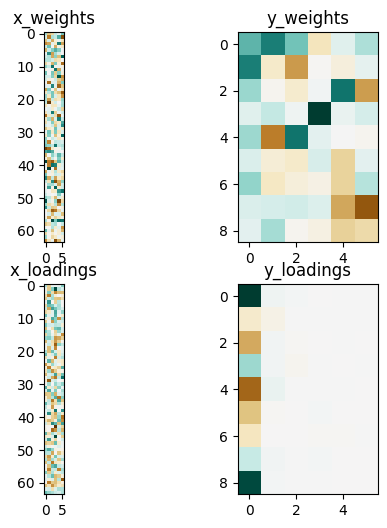

In [268]:
dict_outcome_cca = {
    'x_weights': cca.x_weights_,
    'y_weights': cca.y_weights_,
    'x_loadings': cca.x_loadings_,
    'y_loadings': cca.y_loadings_
}

fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax = ax.flatten()
for ii, (key, val) in enumerate(dict_outcome_cca.items()):
    print(f"{key}: {val.shape}")
    print(f'Min, max: {np.min(val)}, {np.max(val)}')
    im = ax[ii].imshow(val, cmap='BrBG', vmin=-np.max(np.abs(val)), vmax=np.max(np.abs(val)))
    ax[ii].set_title(key)

Text(0, 0.5, 'features (X)')

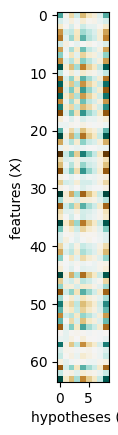

In [270]:
plt.imshow(np.dot(dict_outcome_cca['x_loadings'], dict_outcome_cca['y_loadings'].T), cmap='BrBG')
plt.xlabel('hypotheses (Y)')
plt.ylabel('features (X)')

In [227]:

# Get names of hypotheses: different coarse land coverage classes
names = [k for k in du.create_cmap_dynamic_world().keys()]

In [5]:

# Get names of hypotheses: different coarse land coverage classes
names = [k for k in du.create_cmap_dynamic_world().keys()]

# Extract relevant dimensions
radius = 5 # pixels, excluding center pixel (so diameter = 2 * radius + 1)
N_features = features[0].shape[0]
N_pixels = features[0].shape[1]
N_bands = hypotheses[0].shape[0]


In [6]:

# Precalculate for each pixel which values need to be read and written
read = np.zeros([N_pixels, N_pixels, 2, 2], dtype=int)
write = np.zeros([N_pixels, N_pixels, 2, 2], dtype=int)
for row in range(N_pixels):
    for col in range(N_pixels):
        # Choose region of this band to read out
        read[row, col, 0, 0] = max(0, row - radius) # row start
        read[row, col, 0, 1] = min(row + radius + 1, N_pixels) # row stop
        read[row, col, 1, 0] = max(0, col - radius) # col start
        read[row, col, 1, 1] = min(col + radius + 1, N_pixels) # col stop
        # Choose where in the roi to write this to
        write[row, col, 0, 0] = read[row, col, 0, 0] - (row-radius)
        write[row, col, 0, 1] = write[row, col, 0, 0] + (read[row, col, 0, 1] - read[row, col, 0, 0])
        write[row, col, 1, 0] = read[row, col, 1, 0] - (col - radius)
        write[row, col, 1, 1] = write[row, col, 1, 0] + (read[row, col, 1, 1] - read[row, col, 1, 0])


In [230]:
## ROI = 11x11 hypothesis values focussed around focal pixel (per h, per focal pixel)
## STA = 11x11 ROI * 1x1 embed of focal pixel (per embed, per focal pixel) -> averaged across foxal pixels = 11x11 per embed, per h
## patch_stas = (10, (9, 64, 11, 11)) (patch, h, embed, 11x11)
## all_stas = (9, 64, 11, 11) (h, embed, 11x11)


In [7]:

# Run through all patches, collecting spike triggered averages for each feature for each hypothesis
patch_stas = []
for p, (hypothesis, feature) in enumerate(zip(hypotheses, features)):
    print(f'Analysing patch {p+1} / {len(hypotheses)}')
    # Create empty region of interest maps: area around each pixel for each band
    rois = np.full([N_bands, N_pixels, N_pixels, radius * 2 + 1, radius * 2 + 1], np.nan)
    
    # Collect searchlight data for each pixel from all bands of current modality
    for b, band in enumerate(hypothesis):
        print(f'Copying band {b} / {len(hypothesis)}')
        for row in range(N_pixels):
            for col in range(N_pixels):
                # Grab the relevant pixels from the band
                rois[b, row, col, write[row, col, 0, 0]:write[row, col, 0, 1], write[row, col, 1, 0]:write[row, col, 1, 1]] = \
                    band[read[row, col, 0, 0]:read[row, col, 0, 1], read[row, col, 1, 0]:read[row, col, 1, 1]]
                    
    # Collect spike time averages for each band
    stas = []
    for b, band_rois in enumerate(rois):
        print(f'Calculating spike triggered averages for band {b} / {len(rois)}')
        # Then create the spike time average: multiply each roi by the pixel value of the feature pixel
        band_stas = [band_rois * d[:,:,None,None] for d in feature]
        # Then average across all pixels and stack to get big output array
        band_stas = np.stack([np.nansum(sta.reshape([-1, radius*2+1, radius*2+1]), axis=0) for sta in band_stas])
        # And append to output stas
        stas.append(band_stas)
    patch_stas.append(np.stack(stas))
# Average across patches to get final stas
all_stas = np.nanmean(np.stack(patch_stas), axis=0)
    

Analysing patch 1 / 10
Copying band 0 / 9
Copying band 1 / 9
Copying band 2 / 9
Copying band 3 / 9
Copying band 4 / 9
Copying band 5 / 9
Copying band 6 / 9
Copying band 7 / 9
Copying band 8 / 9
Calculating spike triggered averages for band 0 / 9
Calculating spike triggered averages for band 1 / 9
Calculating spike triggered averages for band 2 / 9
Calculating spike triggered averages for band 3 / 9
Calculating spike triggered averages for band 4 / 9
Calculating spike triggered averages for band 5 / 9
Calculating spike triggered averages for band 6 / 9
Calculating spike triggered averages for band 7 / 9
Calculating spike triggered averages for band 8 / 9
Analysing patch 2 / 10
Copying band 0 / 9
Copying band 1 / 9
Copying band 2 / 9
Copying band 3 / 9
Copying band 4 / 9
Copying band 5 / 9
Copying band 6 / 9
Copying band 7 / 9
Copying band 8 / 9
Calculating spike triggered averages for band 0 / 9
Calculating spike triggered averages for band 1 / 9
Calculating spike triggered averages for

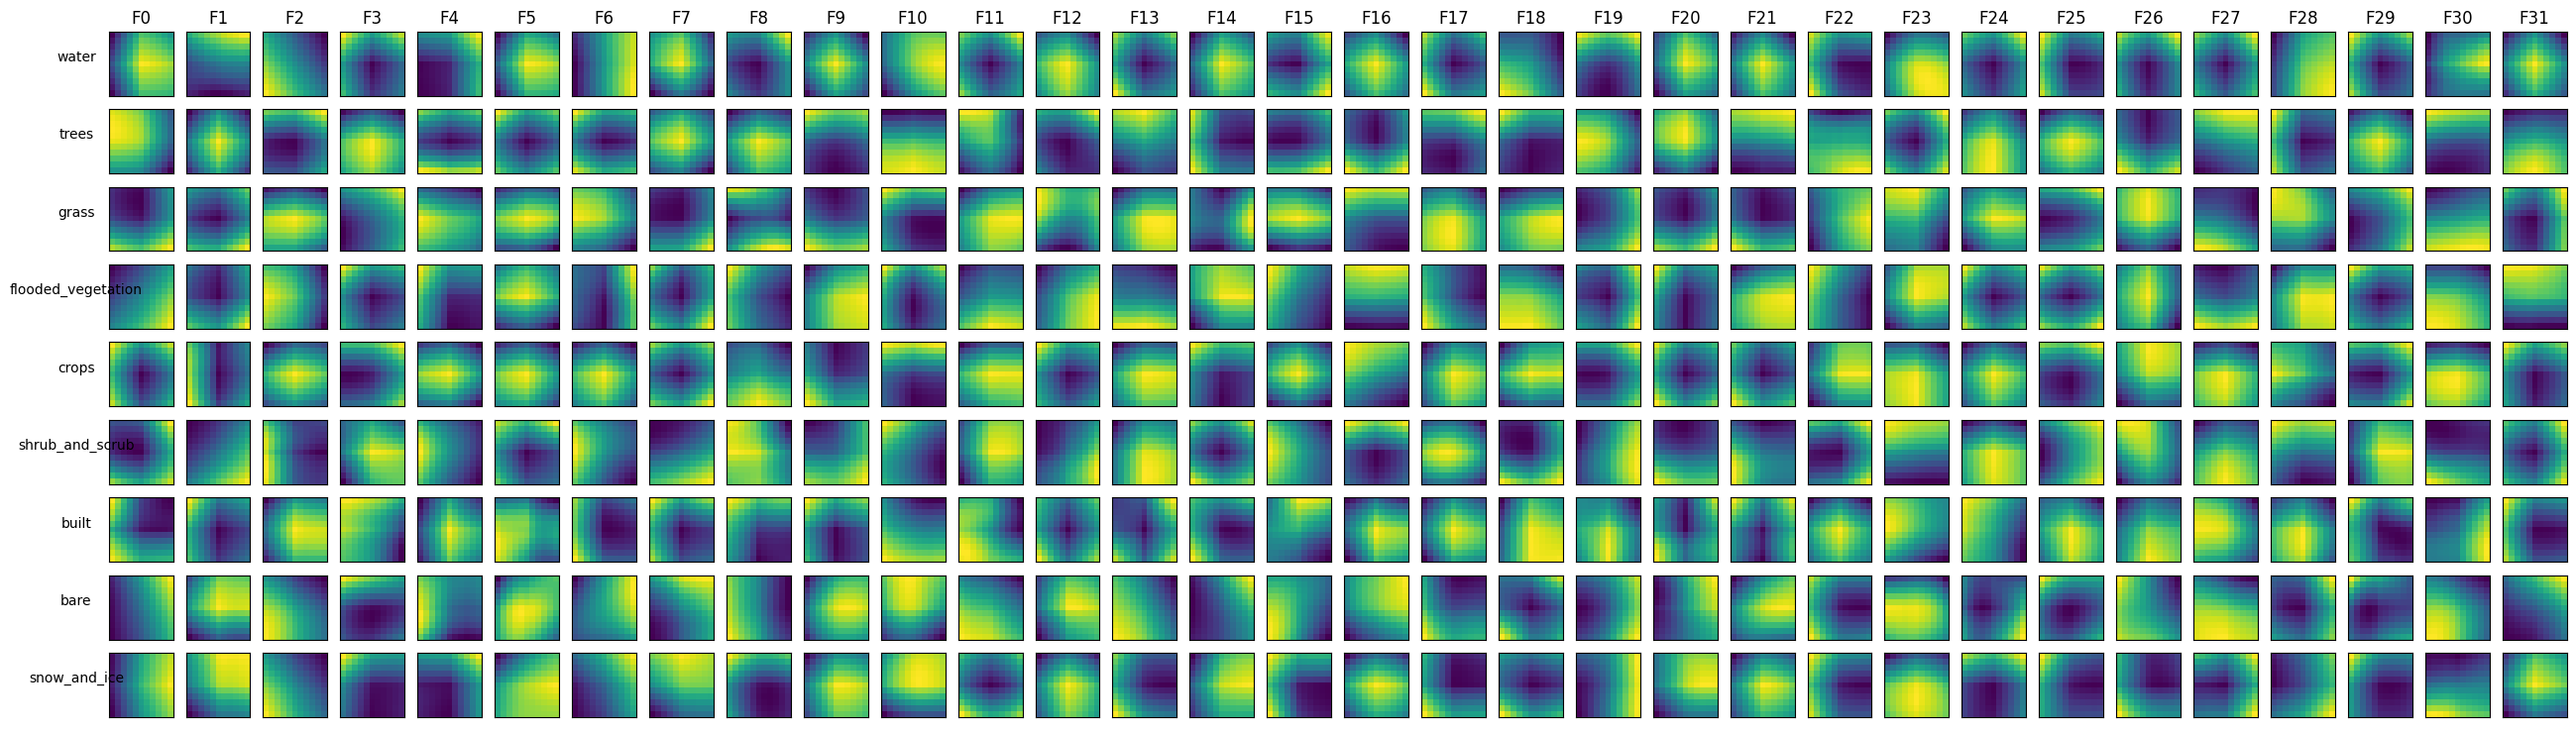

In [16]:
# # Plot a selection
# b_to_plot = len(all_stas)
# f_to_plot = 32
# plt.figure(figsize=(f_to_plot, b_to_plot))
# lim = np.nanmax(np.abs(all_stas[:b_to_plot, :f_to_plot])) / 2
# for row, band_stas in enumerate(all_stas[:b_to_plot]):
#     for col, sta in enumerate(band_stas[:f_to_plot]):
#         plt.subplot(b_to_plot, f_to_plot, row * f_to_plot + col + 1)
#         # plt.imshow(sta, vmin=-lim, vmax=lim, cmap="RdBu_r", interpolation='none') # Minus sign to make blue -> red
#         lim = np.max(np.abs(sta))
#         plt.imshow(sta, cmap='RdBu_r', vmax=lim, vmin=-lim, interpolation='none')
#         # plt.imshow(sta, cmap='viridis')
#         plt.xticks([])
#         plt.yticks([])
#         if col == 0:
#             plt.ylabel(names[row], rotation=0, labelpad=20)
#         if row == 0:
#             plt.title(f'F{col}')


# Plot a selection
b_to_plot = len(all_stas)
f_to_plot = 32
common_scale = False
plt.figure(figsize=(f_to_plot, b_to_plot))
lim = np.nanmax(np.abs(all_stas[:b_to_plot, :f_to_plot]))
for row, band_stas in enumerate(all_stas[:b_to_plot]):
    for col, sta in enumerate(band_stas[:f_to_plot]):
        plt.subplot(b_to_plot, f_to_plot, row * f_to_plot + col + 1)
        plt.imshow(sta, cmap='RdBu_r' if common_scale else 'viridis', 
                   vmin=-lim if common_scale else np.nanmin(sta), 
                   vmax=lim if common_scale else np.nanmax(sta))
        plt.xticks([])
        plt.yticks([])
        if col == 0:
            plt.ylabel(names[row], rotation=0, labelpad=20)
        if row == 0:
            plt.title(f'F{col}')
            

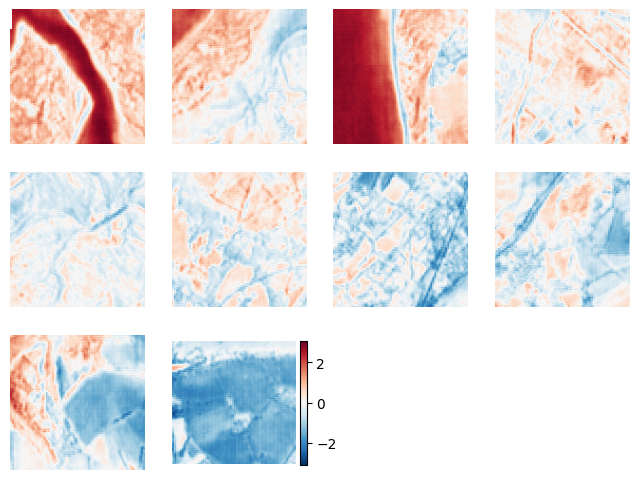

In [17]:
# Plot the map for a particular feature that you might like across patches
curr_f = 31


cols=4
rows=int(np.ceil(patches/cols))
lim = np.nanmax(np.abs(np.stack(features, axis=-1)[curr_f]))

plt.figure(figsize=(2*cols, 2*rows))
for p, feature in enumerate(features):
    plt.subplot(rows, cols, p + 1)
    plt.imshow(feature[curr_f], vmin=-lim, vmax=lim, cmap="RdBu_r")
    plt.axis('off')
    if p == len(features) - 1:
        plt.colorbar(fraction=0.046, pad=0.04)


In [19]:
# # Plot the map for a particular feature that you might like across patches
# # curr_f = 17

# cols=4
# rows=int(np.ceil(patches/cols))
# lim = np.nanmax(np.abs(np.stack(features, axis=-1)[curr_f]))

# plt.figure(figsize=(2*cols, 2*rows))
# for p, feature in enumerate(features_original):
#     plt.subplot(rows, cols, p + 1)
#     plt.imshow(feature[curr_f], vmin=-lim, vmax=lim, cmap="RdBu_r")
#     plt.axis('off')
#     if p == len(features_original) - 1:
#         plt.colorbar(fraction=0.046, pad=0.04)


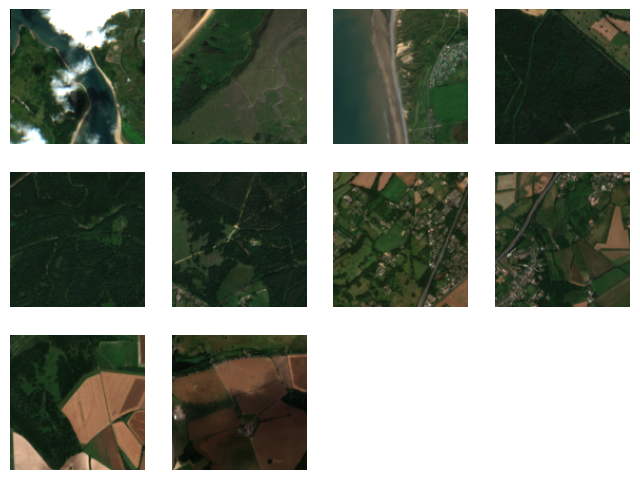

In [14]:

plt.figure(figsize=(2*cols, 2*rows))
for p, sent in enumerate(sentinel):
    plt.subplot(rows, cols, p + 1)
    plt.imshow(np.clip(np.swapaxes(np.swapaxes(sent[:3], 0, 2), 0, 1), 0, 3000) / 3000)
    plt.axis('off')

# TMP